# Kerasによる分析の実行

kerasのLSTMモデルを用いて、移動平均と価格（終値）との距離から一定時間後の距離の期待値を求める

## 前提

## 準備

### 必要なモジュールをimportする

In [ ]:
# データ操作用ライブラリ
import numpy as np
import pandas as pd

# 基本ライブラリ
import os
import sys
import getopt
import time
import math
from decimal import Decimal, ROUND_HALF_UP, ROUND_HALF_EVEN

# 機会学習用ライブラリ
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import SimpleRNN
from tensorflow.keras.layers import GRU
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger
from tensorflow.keras import optimizers
from tensorflow.keras import backend as K

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix

# 進捗確認用プログレスバー
from tqdm.notebook import tqdm

# データアンダーサンプリング用ライブラリ
from imblearn.under_sampling import RandomUnderSampler

# グラフ用
from matplotlib import pyplot as plt

### 定数定義

In [ ]:
# 中間層の数
NUM_MIDDLE = 200

# ニューラルネットのモデルの定数
batch_size = 32   # 1回で投入するデータ量
time_steps = 288  # 5M足で1日分
epochs = 100 # モデル構築練習用の仮置き
validation_split = 0.25 # validationデータの割合
output_gap = 5    # 今回は各行にあるlabel列が教師データとなるため、時系列データとのgapは無い → やめ、close列のoutput_gap本後の価格で判定することにする
value_gap = 5     # pips。現在価格からvalue_gap価格変動があると予想した場合に売買する
learning_rate=0.0001  # 学習率

## データ読み込み

### 学習データを読み込み

In [ ]:
# データファイル読み込み
df = pd.read_csv(
    'drive/MyDrive/FX/AI/data/shaped/DAT_ASCII_USDJPY_M1_2021_CONV.csv',
    sep=',',
    # names=('date', 'open', 'high', 'low', 'close', 'spread'),
    converters={'open': Decimal, 'high': Decimal, 'low': Decimal, 'close': Decimal, 'Lema': Decimal, "Mema": Decimal, "Sema": Decimal,
                "L_Mdiff": Decimal, "L_Sdiff": Decimal, "L_Cdiff": Decimal, "M_Sdiff": Decimal, "M_Cdiff": Decimal, "S_Cdiff": Decimal, "weekday": Decimal},
    )

In [ ]:
df.head()

,open,high,low,close,Lema,Mema,Sema,L_Mdiff,L_Sdiff,L_Cdiff,M_Sdiff,M_Cdiff,S_Cdiff,weekday,feature,label
0,103.097000,103.197000,103.097000,103.195000,103.195,103.195,103.195,0.000,0.000,0.000000,0.000,0.000000,0.000000,6,0.032,0
1,103.195000,103.238000,103.195000,103.213000,103.1952,103.1955,103.1964,-0.0003,-0.0012,-0.017800,-0.0009,-0.017500,-0.016600,6,0.016,0
2,103.213000,103.229000,103.213000,103.213000,103.1954,103.1959,103.1977,-0.0005,-0.0023,-0.017600,-0.0018,-0.017100,-0.015300,6,0.016,0
3,103.213000,103.213000,103.212000,103.213000,103.1955,103.1964,103.1988,-0.0009,-0.0033,-0.017500,-0.0024,-0.016600,-0.014200,6,-0.014,0
4,103.213000,103.229000,103.212000,103.213000,103.1957,103.1968,103.1999,-0.0011,-0.0042,-0.017300,-0.0031,-0.016200,-0.013100,6,-0.020,0


In [ ]:
df.shape

(74627, 16)

この時点での2軸のグラフを表示しておきたい

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 20870 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 20870 missing from current font.
  font.set_text(s, 0, flags=flags)


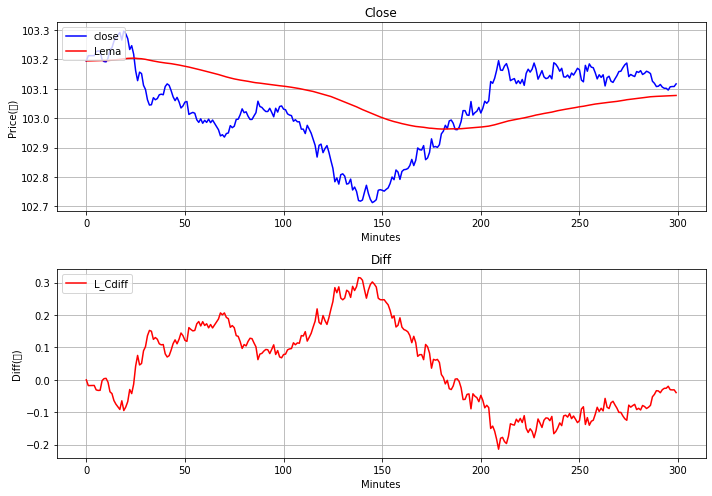

In [ ]:
fig = plt.figure(figsize=(10,7))
ax1 = fig.add_subplot(2, 1, 1)  # 例えば(338)とした場合、figを3x3の9ますに分けて8番目(中の下)にグラフエリアが作られる
ax1.plot(df[:300]['close'], label='close', color='blue')
ax1.plot(df[:300]['Lema'], label='Lema', color='red')
ax1.set_xlabel('Minutes')
ax1.set_ylabel('Price(円)')
ax1.set_title('Close')
ax1.grid()
h1, l1 = ax1.get_legend_handles_labels()
ax1.legend(h1, l1, loc='upper left')

ax2 = fig.add_subplot(2, 1, 2)
ax2.plot(df[:300]['L_Cdiff'], label='L_Cdiff', color='red')
ax2.set_xlabel('Minutes')
ax2.set_ylabel('Diff(円)')
ax2.set_title('Diff')
ax2.grid()
h2, l2 = ax2.get_legend_handles_labels()
ax2.legend(h2, l2, loc='upper left')

fig.tight_layout()

plt.show()

### アンダーサンプリング用に間引き後のインデックスを取得する

In [ ]:
# ラベルに偏りがある
y_class = df['label']
y_class.value_counts()

 0    59145
 1     7859
-1     7623
Name: label, dtype: int64

In [ ]:
strategy = {
    0:y_class.value_counts()[1]*2,  # 0は1の倍くらい
    1:y_class.value_counts()[1],
    -1:y_class.value_counts()[-1],
    }

In [ ]:
rus = RandomUnderSampler(random_state=0, sampling_strategy = strategy)
resample_idx, _ = rus.fit_resample(pd.DataFrame(df.index), y_class)

In [ ]:
# yが間引かれていることを確認する
y_class[resample_idx[0].values.tolist()].value_counts() # valuesで一度nbarrayにし、それをさらにtolistでlist型にする

 0    15718
 1     7859
-1     7623
Name: label, dtype: int64

### 入力データを正規化

最小値・最大値を事前に定義できるらしい  
https://qiita.com/Qiitaman/items/c94420e8b86aae5f28a9

In [ ]:
feature_columns=["close", "Lema", "Mema", "Sema", "L_Mdiff", "L_Sdiff", "L_Cdiff", "M_Sdiff", "M_Cdiff", "S_Cdiff"]

In [ ]:
# sklearnの機能(0～1への正規化の例)
# fit:データを変換するために必要な統計情報を計算します. 変換はまだ行われません. ex.(0, 1, 2) -> 1 / 2 x が、算出される（たぶん）
# transform:fit の結果を使って、実際にデータを変換します. ex.(0,1,2) -> 上記を計算 -> (0, 0.5, 1)
# fit_transform:上記の組み合わせ.
min_max_scaler = MinMaxScaler()
X_array = min_max_scaler.fit_transform(df.loc[:,feature_columns].values)

In [ ]:
X_array

array([[0.0460511 , 0.03438851, 0.04007201, ..., 0.46079447, 0.44794366,
        0.52500214],
       [0.04744894, 0.0344044 , 0.04011132, ..., 0.45924007, 0.43631652,
        0.51076422],
       [0.04744894, 0.03442029, 0.04014277, ..., 0.45768566, 0.43658229,
        0.51187923],
       ...,
       [0.96909218, 0.97915078, 0.97417372, ..., 0.47150259, 0.44488738,
        0.51573891],
       [0.97017939, 0.97915872, 0.97421303, ..., 0.46891192, 0.43591788,
        0.50544644],
       [0.97064534, 0.97917461, 0.9742602 , ..., 0.46614853, 0.43233008,
        0.50218715]])

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 20870 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 20870 missing from current font.
  font.set_text(s, 0, flags=flags)


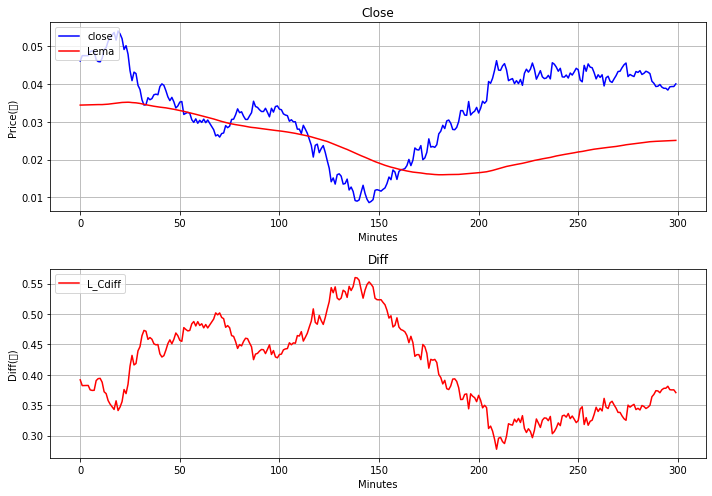

In [ ]:
fig = plt.figure(figsize=(10,7))
ax1 = fig.add_subplot(2, 1, 1)  # 例えば(338)とした場合、figを3x3の9ますに分けて8番目(中の下)にグラフエリアが作られる
ax1.plot(X_array[:300, 0], label='close', color='blue')
ax1.plot(X_array[:300, 1], label='Lema', color='red')
ax1.set_xlabel('Minutes')
ax1.set_ylabel('Price(円)')
ax1.set_title('Close')
ax1.grid()
h1, l1 = ax1.get_legend_handles_labels()
ax1.legend(h1, l1, loc='upper left')

ax2 = fig.add_subplot(2, 1, 2)
ax2.plot(X_array[:300, 6], label='L_Cdiff', color='red')
ax2.set_xlabel('Minutes')
ax2.set_ylabel('Diff(円)')
ax2.set_title('Diff')
ax2.grid()
h2, l2 = ax2.get_legend_handles_labels()
ax2.legend(h2, l2, loc='upper left')

fig.tight_layout()

plt.show()

### 2次元表から1次元追加し、TimeFrameごとのデータを作る

In [ ]:
#インプットと正解データのセットを作る
# input_data: 入力の行列。
def build_timeseries(input_data, label_data, time_steps, output_gap):
    dimention_0 = input_data.shape[0] - time_steps - output_gap
    dimention_1 = input_data.shape[1]
    x = np.zeros((dimention_0, time_steps, dimention_1))  # time_steps行、dimention_1列の行列をdimenstion_0個作る
    y = np.zeros((dimention_0,))
    for i in tqdm(range(dimention_0)):
        x[i] = input_data[i:i+time_steps] # time_steps分の行を取り出して、1回目の入力データとしてxに入れる。1行ずつずらしながら繰り返す
        y[i] = label_data[i+time_steps] # 今回はlabel_dataにすでにoutput_gap本後、の考慮は入っているので改めて入れる必要はない
    print("length of time-series i/o", x.shape, y.shape)
    return x, y

In [ ]:
y_class = df['label']

In [ ]:
# 入力データからインプットとアウトプットのセットを作成(間引き前)
X_all, y_all = build_timeseries(X_array, y_class, time_steps, output_gap)

  0%|          | 0/74334 [00:00<?, ?it/s]

length of time-series i/o (74334, 288, 10) (74334,)


### アンダーサンプリングの適用

In [ ]:
y_all_df = pd.DataFrame(y_all)

In [ ]:
y_all_df[0].value_counts()

 0.0    58901
 1.0     7836
-1.0     7597
Name: 0, dtype: int64

In [ ]:
strategy = {
    0:y_all_df[0].value_counts()[1.0]*2,  # 0は1の倍くらい
    1:y_all_df[0].value_counts()[1.0],
    -1:y_all_df[0].value_counts()[-1.0],
    }

In [ ]:
# 取得されるindexは、どうやら列0～ソートされて取得されるらしい
rus = RandomUnderSampler(random_state=0, sampling_strategy = strategy)
resample_idx, _ = rus.fit_resample(pd.DataFrame(y_all_df.index), y_all_df)

In [ ]:
# 入力データから前半288本はXに含まれないが、Xとしては"0"から始まっているので後半288本が存在しない、ということである
# resample_idxの(カラム'0'の)番号"289"が、X_allのindex='0'に対応しているはず。なので調整が必要
X = X_all[resample_idx[0].values.tolist()]
y = y_all[resample_idx[0].values.tolist()]

In [ ]:
len(X)

31105

In [ ]:
pd.DataFrame(y).value_counts().sum()

31105

### LabelをOneHotVector変換

[sklearn.preprocessing.OneHotEncoder](https://mathwords.net/fittransform)

設定を保存<br>
https://zerofromlight.com/blogs/detail/71/#_5

In [ ]:
y.shape

(31105,)

In [ ]:
y.reshape(-1, 1).shape

(31105, 1)

In [ ]:
y

array([-1., -1., -1., ...,  1.,  1.,  1.])

In [ ]:
y.reshape(-1, 1)

array([[-1.],
       [-1.],
       [-1.],
       ...,
       [ 1.],
       [ 1.],
       [ 1.]])

In [ ]:
from sklearn.preprocessing import OneHotEncoder
categories = [-1, 0, 1]

encoder = OneHotEncoder(categories=[categories])

encoder_data = encoder.fit_transform(y.reshape(-1, 1))    # df["label"] -> labelのseries, values -> arrayに, reshape(-1, 1) -> 1列, 行は自動推定
y_one = encoder_data.toarray().astype('int64')

In [ ]:
print(f'-1 = { y_one.sum(axis=0)[0] }, 0 = { y_one.sum(axis=0)[1] }, 1 = { y_one.sum(axis=0)[2] }')

-1 = 7597, 0 = 15672, 1 = 7836


### データを学習用と検証用に分割

Xとyの対応を維持するためにも、shuffleをTrueにするならそのseed？を同じにしないといけないんじゃないか？？  
これ https://qiita.com/KyleKatarn/items/2afa6787f04f28e2cd2d

In [ ]:
random_state = 20220508

In [ ]:
X_train, X_test = train_test_split(X, train_size=0.8, test_size=0.2, shuffle=True, random_state=random_state)
print("Train-Test size", len(X_train), len(X_test))

Train-Test size 24884 6221


In [ ]:
y_train, y_test = train_test_split(y_one, train_size=0.8, test_size=0.2, shuffle=True, random_state=random_state)
print("Train-Test size", len(y_train), len(y_test))

Train-Test size 24884 6221


In [ ]:
y_train.sum(axis=0)

array([ 6077, 12580,  6227])

In [ ]:
y_test.sum(axis=0)

array([1520, 3092, 1609])

データを分割しただけではindexは振り直されないようなので、明示的にリセットする（これを行わないと先頭が5,000～とかなってしまう）  
と思ったけど、ndarrayだからそういうの関係ないか…（DataFrameだと上記が必要）

In [ ]:
# y_train = y_train.reset_index(drop=True)
# y_test = y_test.reset_index(drop=True)

In [ ]:
# y_train.head()

In [ ]:
# y_test.head()

### 半端なデータを切り捨てる

In [ ]:
# バッチサイズからはみ出た要素を削除する
def trim_dataset(input_data, batch_size):
    no_of_rows_drop = input_data.shape[0]%batch_size
    if no_of_rows_drop > 0:
        return input_data[:-no_of_rows_drop]
    else:
        return input_data

In [ ]:
x_t = trim_dataset(X_train, batch_size)   # 学習データ
y_t = trim_dataset(y_train, batch_size)   # ラベルデータ
print("Batch trimmed size",X_train.shape, y_train.shape)

Batch trimmed size (24884, 288, 10) (24884, 3)


In [ ]:
x_t[0][0] # 入力0個目のローソク0本目の各要素

array([0.54275064, 0.53936245, 0.53800434, 0.54014062, 0.42729109,
       0.41320856, 0.37019487, 0.4074266 , 0.40641818, 0.49789862])

In [ ]:
y_t[0]

array([0, 0, 1])

### テスト用データをさらにvalidateとtestに分ける

In [ ]:
# validateは、ハイパーパラメータを決定するために使用するもの. 学習には使わない
# testは、未知のデータに対する予測精度を評価するために使用するもの. 学習には使わない
# x_temp, y_temp = build_timeseries(X_test, y_test, time_steps, output_gap)
# x_val, x_test_t = np.split(trim_dataset(x_temp, batch_size),2)    # 予測のネタデータ
# y_val, y_test_t = np.split(trim_dataset(y_temp, batch_size),2)    # ラベルデータ

x_val, x_test_t = np.split(trim_dataset(X_test, batch_size),2)    # 予測のネタデータ
y_val, y_test_t = np.split(trim_dataset(y_test, batch_size),2)    # ラベルデータ

In [ ]:
x_test_t[0][0]   # 1次元目:今回予測したいタイムフレーム数, 2:1タイムフレームにおける時間数(=足数), 3:特徴(列)数

array([0.18288421, 0.17075864, 0.17718324, 0.18091238, 0.36468064,
       0.37800107, 0.3674795 , 0.41381693, 0.43598432, 0.53289304])

In [ ]:
y_test_t[0]

array([0, 1, 0])

### データまとめ（確認用）

In [ ]:
# モデル学習用データ
x_t[:1]        # 予測対象データ(X)

array([[[0.54275064, 0.53936245, 0.53800434, ..., 0.4074266 ,
         0.40641818, 0.49789862],
        [0.54150812, 0.53938628, 0.53809868, ..., 0.4074266 ,
         0.41784599, 0.51265117],
        [0.54181875, 0.53941012, 0.53820089, ..., 0.40708117,
         0.41605209, 0.5105069 ],
        ...,
        [0.54950687, 0.54968377, 0.54988364, ..., 0.47702936,
         0.44900671, 0.51831203],
        [0.54950687, 0.54968377, 0.54988364, ..., 0.47599309,
         0.44900671, 0.51882666],
        [0.54772074, 0.54966787, 0.54982861, ..., 0.47685665,
         0.463823  , 0.53752466]]])

In [ ]:
y_t[:1]        # 正解データ(Y)

array([[0, 0, 1]])

In [ ]:
# ハイパーパラメータ調整用データ
x_val[:1]

array([[[0.42952551, 0.43590294, 0.43324476, ..., 0.57789292,
         0.48980134, 0.52088515],
        [0.42944785, 0.43581554, 0.43311897, ..., 0.5746114 ,
         0.4894027 , 0.52200017],
        [0.4304574 , 0.43572813, 0.43301676, ..., 0.57029361,
         0.47990167, 0.51187923],
        ...,
        [0.42704046, 0.42418319, 0.42587031, ..., 0.46062176,
         0.44874095, 0.52611716],
        [0.42742875, 0.42419114, 0.42587817, ..., 0.46027634,
         0.44548535, 0.52208594],
        [0.42781704, 0.42419908, 0.4258939 , ..., 0.45958549,
         0.44229619, 0.51831203]]])

In [ ]:
y_val[:1]

array([[0, 1, 0]])

In [ ]:
# 評価用データ
x_test_t[:1]

array([[[0.18288421, 0.17075864, 0.17718324, ..., 0.41381693,
         0.43598432, 0.53289304],
        [0.18451503, 0.17081426, 0.17726186, ..., 0.41398964,
         0.42269617, 0.51565314],
        [0.18482566, 0.17086988, 0.17734834, ..., 0.41381693,
         0.42076938, 0.51325157],
        ...,
        [0.18653413, 0.17824339, 0.1819161 , ..., 0.46165803,
         0.4447545 , 0.5204563 ],
        [0.18754368, 0.17825133, 0.18194755, ..., 0.45993092,
         0.43638296, 0.5105069 ],
        [0.18940747, 0.17828312, 0.18203403, ..., 0.45647668,
         0.42116803, 0.49258084]]])

In [ ]:
y_test_t[:1]

array([[0, 1, 0]])

## 分析の実施

### モデルの作成

In [ ]:
# LSTMニューラルネットワークの構築
model = Sequential()
model.add(
    LSTM(
        NUM_MIDDLE,   # 中間層のレイヤーの数
        batch_input_shape=(batch_size, time_steps, len(feature_columns)),   # inputの形
        dropout=0.0,    # 過学習防止用. 意図的にニューロン間の接続を切る. 0.01で1%
        recurrent_dropout=0.0,    # ？
        stateful=True,    # 次バッチに状態を持ち越す
        return_sequences=True,    # 1エポックの最終結果だけでなく、エポック中の時系列の途中途中も評価対象にする(https://qiita.com/everylittle/items/b6f08891c1da41f30b24)
        kernel_initializer='random_uniform',  # 初期化
      )
    )
model.add(Dropout(0.4))
model.add(LSTM(60, dropout=0.0))
model.add(Dropout(0.4))
model.add(Dense(20, activation='relu'))
model.add(Dense(y_t.shape[1], activation='softmax'))   # 出力サイズはOneHotで生成した列数にしたい

optimizer = optimizers.Adam(lr=learning_rate)
# model.compile(loss='mean_squared_error', optimizer=optimizer) # スカラ(将来の価格)を予測する場合はこちら
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=["accuracy"]) # 
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (32, 288, 200)            168800    
                                                                 
 dropout (Dropout)           (32, 288, 200)            0         
                                                                 
 lstm_1 (LSTM)               (32, 60)                  62640     
                                                                 
 dropout_1 (Dropout)         (32, 60)                  0         
                                                                 
 dense (Dense)               (32, 20)                  1220      
                                                                 
 dense_1 (Dense)             (32, 3)                   63        
                                                                 
Total params: 232,723
Trainable params: 232,723
Non-trai

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


### 学習

https://keras.io/ja/callbacks/

In [ ]:
# 監視する値の変化が停止した時に訓練を終了します
es = EarlyStopping(
    monitor='val_loss',     # 監視する値
    mode='min',             # 監視する値の"減少"が停止した際に訓練終了
    verbose=1,              # 冗長モード(0:結果非表示, 1:結果表示)
    patience=5,             # 指定したエポック数、改善がないと訓練終了
    min_delta=0.0001        # 改善したと判定される最小変化値
    )

In [ ]:
# 各エポック終了後にモデルを保存します(https://qiita.com/tom_eng_ltd/items/7ae0814c2d133431c84a)
output = 'drive/MyDrive/FX/AI/model/best_model_USDJPY_5M_' + time.ctime().replace(" ","_") + '.h5'
mcp = ModelCheckpoint(
    output,                   # モデルファイルを保存するパス
    monitor='val_loss',       # 監視する値
    verbose=1,                # 冗長モード(0:結果非表示, 1:結果表示)
    save_best_only=True,      # True:最良のモデルのみが書き出される(最新のモデルで上書きしない？)
    save_weights_only=False,  # True:重みを保存, False:モデル全体を保存
    mode='min',               # val_lossが変化量がminなら保存する、みたいな(val_accで判定するならmaxにする)
    period=1                  # チェックポイント間の間隔(エポック数). save_best_only=Trueのとき無視(？)
    )

In [ ]:
# 各エポックの結果をcsvファイルに保存するコールバックです
logdir = "drive/MyDrive/FX/AI/log/"
csv_logger = CSVLogger(
    os.path.join(
        logdir,               # 出力先ディレクトリ
        'training_log_' + time.ctime().replace(" ","_") + '.log'),  # 出力ファイル名
    append=True               # 追記モード
    )

In [ ]:
# 学習実施
history = model.fit(
    # 学習データ
    x_t, 
    y_t, 
    epochs=epochs, 
    verbose=2, 
    batch_size=batch_size,
    shuffle=False,
    # 検証データ 
    validation_data=(
        trim_dataset(x_val, batch_size),
        trim_dataset(y_val, batch_size)
      ), 
    callbacks=[es, mcp, csv_logger])

Epoch 1/100

Epoch 1: val_loss improved from inf to 1.04340, saving model to drive/MyDrive/FX/AI/model/best_model_USDJPY_5M_Sun_May__8_02:49:14_2022.h5
777/777 - 26s - loss: 1.0411 - val_loss: 1.0434 - 26s/epoch - 34ms/step
Epoch 2/100

Epoch 2: val_loss improved from 1.04340 to 1.04290, saving model to drive/MyDrive/FX/AI/model/best_model_USDJPY_5M_Sun_May__8_02:49:14_2022.h5
777/777 - 18s - loss: 1.0377 - val_loss: 1.0429 - 18s/epoch - 23ms/step
Epoch 3/100

Epoch 3: val_loss improved from 1.04290 to 1.04225, saving model to drive/MyDrive/FX/AI/model/best_model_USDJPY_5M_Sun_May__8_02:49:14_2022.h5
777/777 - 18s - loss: 1.0370 - val_loss: 1.0422 - 18s/epoch - 23ms/step
Epoch 4/100

Epoch 4: val_loss improved from 1.04225 to 1.04182, saving model to drive/MyDrive/FX/AI/model/best_model_USDJPY_5M_Sun_May__8_02:49:14_2022.h5
777/777 - 18s - loss: 1.0360 - val_loss: 1.0418 - 18s/epoch - 23ms/step
Epoch 5/100

Epoch 5: val_loss did not improve from 1.04182
777/777 - 18s - loss: 1.0378 - v

In [ ]:
# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

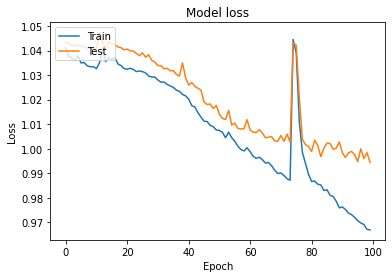

In [ ]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

## 結果の検証

In [ ]:
# テストデータ
x_real = trim_dataset(x_test_t, batch_size)
y_real = trim_dataset(y_test_t, batch_size)

In [ ]:
# モデル読み込み
input_modelfile = output
model = load_model(input_modelfile)

In [ ]:
x_real.shape

(3104, 288, 10)

In [ ]:
# numpyの要素ごとに正規化を行う
# - input: 入力データ
# - output_index: 特徴量の列番号
def min_max_scaler_converter(input, output_index):
    output = []
    data_range = []
    data_shift = []

    for row in input: # 1次元目を取り出す(rowとか言うけど、実態はtime_steps行、14列の行列)
        scaler = MinMaxScaler()                               # 以下の配列については次が詳しい→http://taustation.com/sklearn-preprocessing/
        output.append(scaler.fit_transform(row))              # 正規化後データ
        data_range.append(scaler.data_range_[output_index])   # 最大値－最小値のレンジ. 正規化の復元に使用
        data_shift.append(scaler.data_min_[output_index])     # データセット中の各特徴量の最小値. 正規化の復元に使用
    
    return np.array(output), data_range, data_shift

In [ ]:
# 入力データを正規化
output_index=0
x_real, data_range, data_shift = min_max_scaler_converter(x_real, output_index)

In [ ]:
x_real[0][0]

array([0.32119205, 0.        , 0.04700855, 0.30564784, 0.41210375,
       0.343441  , 0.53220697, 0.28823529, 0.54614767, 0.58736942])

In [ ]:
x_real.shape

(3104, 288, 10)

In [ ]:
len(data_range)

3104

In [ ]:
data_range[0:2]

[0.023452667546790096, 0.03269395045429668]

In [ ]:
# 予測を実行
y_pred = model.predict(trim_dataset(x_real, batch_size), batch_size=batch_size)   # yの予測値

# y_pred = y_pred.flatten()   # numpyのflatten. 1次元にする. flattenはコピーを返す(https://note.nkmk.me/python-numpy-ravel-flatten/)
y_real = trim_dataset(y_real, batch_size)   # yの正解値
error = mean_squared_error(y_real, y_pred)  # 予測値と正解値の平均二乗誤差を取る
print("Error is", error, y_pred.shape, y_real.shape)


Error is 0.2658256169037694 (3104, 3) (3104, 3)


In [ ]:
y_pred[0]

array([0.26287764, 0.25023848, 0.48688388], dtype=float32)

In [ ]:
y_pred.shape

(3104, 3)

In [ ]:
np.argmax(y_pred, axis=1)

array([2, 0, 2, ..., 0, 0, 0])

In [ ]:
np.argmax(y_real, axis=1)

array([1, 1, 2, ..., 1, 0, 2])

In [ ]:
y_real[10:20]

array([[0, 0, 1],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [1, 0, 0]])

In [ ]:
error = mean_squared_error(np.argmax(y_real, axis=1), np.argmax(y_pred, axis=1))  # y_predだと小数になっててちゃんと比較できてるのか怪しいのでargmaxする
print("Error is", error, y_pred.shape, y_real.shape)

Error is 1.3356958762886597 (3104, 3) (3104, 3)


In [ ]:
pd.DataFrame(pd.Series(np.argmax(y_real, axis=1).ravel()).describe()).transpose()

,count,mean,std,min,25%,50%,75%,max
0,3104.0,1.014175,0.705253,0.0,1.0,1.0,2.0,2.0


In [ ]:
# 正解データの内訳
pd.DataFrame(pd.Series(np.argmax(y_real, axis=1).ravel()).value_counts()).transpose()

,1,2,0
0,1560,794,750


In [ ]:
# 予測結果の内訳
pd.DataFrame(pd.Series(np.argmax(y_pred, axis=1).ravel()).value_counts()).transpose()

,0,2,1
0,1515,951,638


予測結果を判定<br>
https://note.nkmk.me/python-sklearn-confusion-matrix-score/

In [ ]:
# 混同行列 横軸:予測, 縦軸:正解
# -------------------------------
#         予測 0  予測 3  予測 4 
# 正解 0  ①      ②
# 正解 3
# 正解 4
# -------------------------------
# ①:正解が0で、予測も0だったパターン
# ②:正解が0で、予測は3だったパターン（＝予測失敗）
# ←多次元だとできないっぽい, ので、argmaxを適用してlabelのインデックスどうしを比較する
confusion_matrix(np.argmax(y_real, axis=1), np.argmax(y_pred, axis=1))

array([[358, 145, 247],
       [746, 342, 472],
       [411, 151, 232]])

In [ ]:
# 正解率
from sklearn.metrics import accuracy_score
accuracy_score(np.argmax(y_real, axis=1), np.argmax(y_pred, axis=1))

0.3002577319587629

In [ ]:
# まとめて分析
from sklearn.metrics import classification_report
classification_report(np.argmax(y_real, axis=1), np.argmax(y_pred, axis=1))

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


'              precision    recall  f1-score   support\n\n           0       0.22      0.12      0.16       750\n           1       0.50      0.86      0.63      1560\n           2       0.00      0.00      0.00       794\n\n    accuracy                           0.46      3104\n   macro avg       0.24      0.33      0.26      3104\nweighted avg       0.30      0.46      0.35      3104\n'

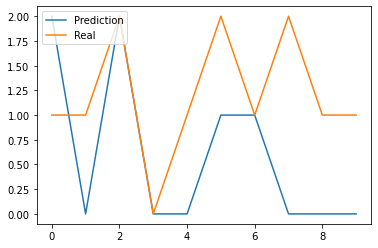

In [ ]:
fig = plt.figure()
plt.plot(np.argmax(y_pred, axis=1)[:10])
plt.plot(np.argmax(y_real, axis=1)[:10])
plt.legend(['Prediction', 'Real'], loc='upper left')
plt.show()
plt.close(fig)

In [ ]:
# どの予測結果が一番可能性が高かったか
np.argmax(y_pred, axis=1)

array([1, 1, 0, ..., 1, 1, 1])